안녕하세요, 이번 포스팅에서는 Word2Vec을 직접 구현해보도록 하겠습니다. 
저번포스팅에서 예고했듯 Word2Vec 중에서도 Skip-gram 모델을 구현하였고 Negative sampling 기법도 적용해보았습니다.

이론적인 배경이 부족하신 분들은 이전 포스팅들(Word2Vec 1,2편)을 참고해주시면 감사하겠습니다.

전체 골격은 아래와 같으며, Main code를 제외한 부분들은 모두 모듈화 한 후 Main code에서 간단하게 실행할 수 있도록 구성했습니다.  
각 파트별로 하나씩 살펴 보도록 하겠습니다.

## Skeleton

- 한국어 텍스트 전처리
- Input / label pair 생성 (Negative sampling 포함)
- Training
- TNSE를 이용한 저차원 투영 및 시각화
- Main code

In [1]:
# 기본 torch library import
import torch
import torch.nn as nn
import torch.nn.functional as F

## 1. 한국어 전처리
 
먼저, 예제 문장이 한국어로 이루어져 있기 때문에 한국어 전처리를 진행해줍니다.  
한국어는 접두사, 조사, 동사의 변형 등의 이유로 영어에 비해 난이도가 훨씬 높지만, 한국어를 이용한 임베딩을 해보고 싶었습니다.  
전처리 기법은 깊이 들어가면 너무 난이도가 높아지므로 Corpus도 최대한 간결하게 준비했습니다.

한국어 전처리 라이브러리 중에서도 문장 분리를 도와주는 kss와 형태소 분석을 도와주는 Mecab, 정규표현식 라이브러리인 re를 사용했습니다.  
정규표현식을 이용하여 이번에 사용한 Corpus에는 해당사항이 없지만 몇 가지 경우에 대한 처리를 예시로 적어보았습니다.

In [2]:
import kss
import re
from konlpy.tag import Mecab

class Prep():
        
    def Clean_text(self, text): # noisy한 문장을 cleaning
        self.sentences = []
        
        for i in range(len(text)):
            if (i+1) % 10 == 0:
                print(str(i+1) + 'th sentence is spliting...')
        
            temp = re.sub("[^가-힣a-z0-9.?]", ' ', text[i]) #한글, 영어, 숫자, 온점, 물음표가 아닌 것을 공백으로 삭제
            temp = re.sub("[.]{2,}", ".", temp) # 반복되는 온점 (...) 삭제
            temp = re.sub("[?]{2,}", "?", temp) # 반복되는 물음표 (?) 삭제
            temp = re.sub("[!]{2,}", "!", temp) # 반복되는 느낌표 (!) 삭제
            temp = re.sub("[' ']{2,}", " ", temp) # 반복되는 공백 삭제 
            temp = kss.split_sentences(temp)  #문장 분리

            for tmp in temp:
                self.sentences.append(tmp)
        
        return self.sentences

        
    def Tokenizer(self, sentences): # cleaned data에 대한 형태소 분석 후 vocabulary 구축
        
        self.corpus = []
        self.words = []
        self.vocab = []
        
        tokenizer = Mecab(dicpath=r"C:\mecab\mecab-ko-dic")
        
        for sent in self.sentences:
            temp = tokenizer.morphs(sent)
            self.corpus.append(temp)
            
            for tmp in temp:
                self.words.append(tmp)

        self.vocab = set(self.words)
        
        return self.corpus, self.words, self.vocab
    
    def Make_dict(self,vocab): # 만들어진 Vocabulary를 기준으로 단어-정수 및 정수-단어 인덱싱 dictionary 생성
        self.word_dict = {w: i for i, w in enumerate(self.vocab)}
        self.index_dict = {i: w for i, w in enumerate(self.vocab)}
    
    def Get_clean(self, text): #위의 세가지 메소드를 한번에 진행                
        sentences =  Prep.Clean_text(text)
        corpus, words, vocab = Prep.Tokenizer(self.sentences)
        word_dict, index_dict = Prep.Make_dict(self.vocab)
        
        return sentences, corpus, words, vocab, word_dict, index_dict

## 2. Input / label pair 생성 (Negative sampling 포함)

먼저, Negative Sampling에 대한 클래스를 먼저 정의했습니다.    
지수는 가장 성능이 좋다고 알려져 있는 3/4로 설정했습니다.  

다음으로, Negative Sampling을 기반으로 각 input과 label을 생성해 주었습니다.  
negative sampling에서 n_negsam개의 sample을 뽑도록 설정했습니다.

Negative sampling은 중심단어에 대한 주변 단어는 반드시 포함하고, 주변단어가 아닌 단어들을 추가적으로 샘플링하는 기법입니다.  
Window size가 2일 경우 문장길이가 충분하고 center word가 중앙에 위치하면 context word는 4개가 되지만, center word가 문장의 가장 앞쪽이나 뒤쪽에 있을때는 2개가 됩니다.   

이런 경우를 해결하기 위해 context word가 부족할경우 추가로 샘플링을 하여 최종적으로는 총 (2 x window size) + negsam 개의 target words가 생성되도록 했습니다.

In [3]:
from collections import defaultdict
import numpy as np

class NegativeSampling():  # Negative Sampling Class
    
    def __init__(self):
        self.wordFreq = defaultdict(int)
        for word in words:
            self.wordFreq[word] += 1
        
        self.SumFreq = sum([freq**(3/4) for freq in self.wordFreq.values()])
        self.wordProb = {word:((freq**(3/4))/self.SumFreq) for word, freq in self.wordFreq.items()}
    
    def Draw(self,n_sample): # n_sample : sample을 몇 개를 뽑을건지?
        negsam = []
        for i in range(n_sample):
            negsam.append(np.random.choice(list(self.wordProb.keys()), p=list(self.wordProb.values()))) #확률분포 p에 따른 추출
    
        return negsam

In [8]:
def make_pairs(window_size, n_negsam): # Input과 target, label을 만들어주는 함수
    
    #initialize
    inputs = [] 
    targets = []
    labels = []

    for c in corpus: # for each sentence          
        for idx in range(len(c)): # for each idx
            start = max(0,idx - window_size)
            tail = min(idx + window_size, len(c)-1)
            
            #add negative samples to context
            context = c[start:idx] + c[idx+1:tail+1]
            needed_negsam = 2*window_size+n_negsam - len(context) # needed number of negative samples
            negsam = NegativeSampling().Draw(wordProb, needed_negsam) # draw negative samples
            
            #stack pairs
            input.append(c[idx])
            targets.append(context+negsam)
            labels.append([1]*len(context) + [0]*needed_negsam)
                  
    return inputs, targets, labels   

## Training



In [7]:
from torch.autograd import Variable
def train(inputs, targets, labels, emb_dim, lr, n_epoch):
    
    target_size = len(targets[0])
    center_mat = Variable(torch.nn.init.xavier_normal(torch.empty(emb_dim, vocab_size)),requires_grad=True).float() # W mat
    context_mat = Variable(torch.nn.init.xavier_normal(torch.empty(vocab_size, emb_dim)),requires_grad=True).float() # W' mat
    
    for epoch in range(n_epoch): 
        loss_value = 0
        for batch in range(len(inputs)): 
            x = word_dict[inputs[batch]] # word index of input
            h = center_mat[:,x]
            
            tar_ind = [word_dict[tar] for tar in targets[batch]]
                
            
            context_tmp = Variable(context_mat[tar_ind,:], requires_grad=True).float()
            z = torch.matmul(context_tmp,h)
            y = torch.LongTensor(labels[batch])

            y_hat = F.log_softmax(z)
            loss = F.nll_loss(y_hat, y)
            loss_value += loss.item()
            loss.backward()
            
            center_mat.data -= lr * center_mat.grad.data
            context_mat.data[tar_ind,:] -= lr * context_tmp.grad.data
            
            center_mat.grad.data.zero_()
            context_tmp.grad.data.zero_()
        
        if epoch % 100 == 0:
            print(f"Loss at this epoch {epoch+100}: {loss_value / vocab_size}")
        
    return center_mat         

In [31]:
import matplotlib.pyplot as plt
#matplotlib 패키지 한글 깨짐 처리 시작
plt.rc('font', family='Malgun Gothic') #윈도우, 구글 콜랩
#plt.rc('font', family='AppleGothic') #맥
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결
#matplotlib 패키지 한글 깨짐 처리 끝

<IPython.core.display.Javascript object>


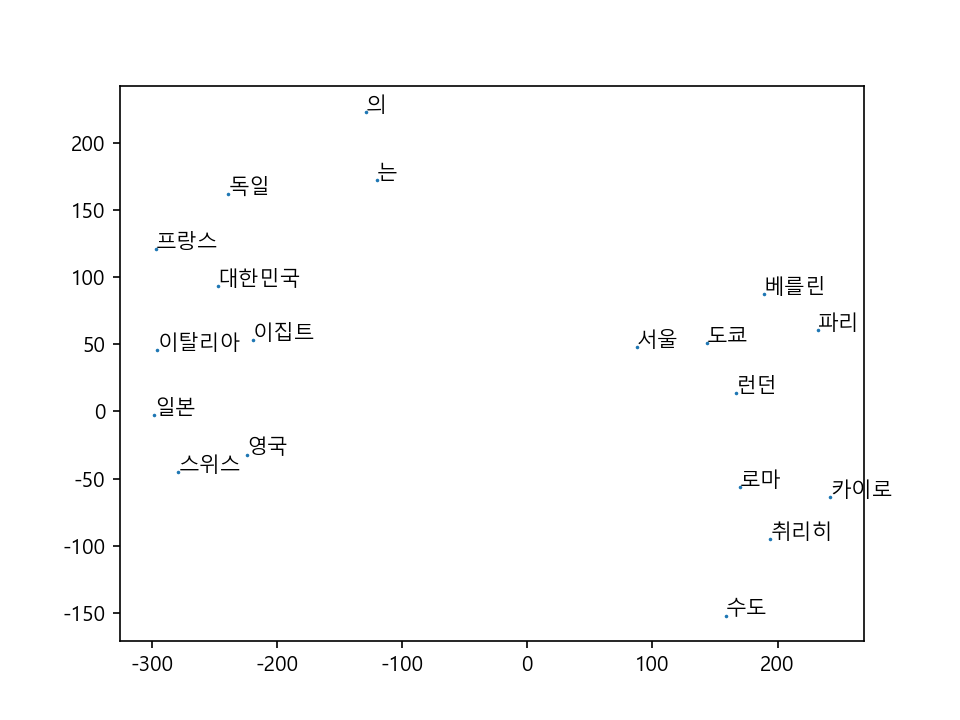

In [36]:
wordvec = np.array(center_mat.data.T.data)

from sklearn.manifold import TSNE
wordvec_2d = TSNE(n_components=2, perplexity=5, learning_rate='auto', init='random').fit_transform(wordvec)

from matplotlib import pyplot as plt
%matplotlib notebook

plt.scatter(wordvec_2d[:,0], wordvec_2d[:,1], s=0.5)

test_words=[]
for i in range(len(vocab)):
    test_words.append(index_dict[i])
    
for i, word in enumerate(test_words):
    plt.annotate(word, xy=(wordvec_2d[i, 0], wordvec_2d[i, 1]))
    

In [ ]:
# 간단한 예제 문장 준비

text = ['대한민국의 수도는 서울',
       '독일의 수도는 베를린',
       '프랑스의 수도는 파리',
       '스위스의 수도는 취리히',
       '일본의 수도는 도쿄',
       '이탈리아의 수도는 로마',
       '영국의 수도는 런던',
       '이집트의 수도는 카이로'
       ]        

prep = Prep()
sentences, corpus, words, vocab = prep.Get_clean(text)

make_pairs(window_size, n_negsam)
center_mat = train(input, targets, labels, 20, 0.01, 1000)

vocab_size = len(vocab)

        